In [ ]:
all_gap_folders = ['g1', 'g2', 'g3', 'g4', 'g5', 'g6', 'g7', 'g8', 'g9', 'g10']

# Initialize an array to store the results
all_gap_timeseries = np.empty((10, 2), dtype=object)

# Iterate over each folder
for i, gap_folder in enumerate(all_gap_folders):
    # Read the gap coordinates for the current folder
    gap_coord = read_gap_coordinates(gap_folder)
    
    # Extract the time series data for the current coordinates
    dates, coord_values = extract_time_series_for_coordinate(gap_folder, gap_coord, filter=False, scale=False)
    
    # Store the lists in the object array
    all_gap_timeseries[i, 0] = dates
    all_gap_timeseries[i, 1] = coord_values

## Above this is possibly redundant code that I dont yet want to delete

In [1]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
import rasterio
from datetime import datetime
from skimage.restoration import denoise_nl_means, estimate_sigma
from skimage import img_as_float
import random
import math
import pandas as pd

In [2]:
def generate_random_coordinates(center, radius, num_points=10):
    """
    Generate random coordinates within a given radius from a center point.
    
    Parameters:
    center (tuple): A tuple containing the UTM coordinates of the center point (easting, northing).
    radius (float): The radius within which to generate the random points (in meters).
    num_points (int): The number of random points to generate. Default is 10.
    
    Returns:
    list: A list of tuples containing the UTM coordinates of the random points.
    """
    center_easting, center_northing = center
    points = []

    for _ in range(num_points):
        angle = random.uniform(0, 2 * math.pi)
        distance = random.uniform(0, radius)
        
        offset_easting = distance * math.cos(angle)
        offset_northing = distance * math.sin(angle)
        
        new_easting = center_easting + offset_easting
        new_northing = center_northing + offset_northing
        
        points.append((new_easting, new_northing))
    
    return points

# Example usage:
center_point = (564536.5, 9516689.6)
radius = 100
random_points = generate_random_coordinates(center_point, radius)

In [3]:
def view_image(file_path):
    """
    View an image given its file path.

    Parameters:
    file_path (str): Filepath to the image file.
    """
    # Open the .tif file
    with rasterio.open(file_path) as dataset:
        # Read the first band
        band1 = dataset.read(1)
        
        # Plot the image
        plt.figure(figsize=(10, 10))
        show(band1, cmap='gray')


# Function to list all .tif files in a folder
def list_tif_files(folder_path):
    return sorted(glob.glob(os.path.join(folder_path, '*.tif')))

# Function to convert UTM coordinates to pixel coordinates
def utm_to_pixel(dataset, utm_x, utm_y):
    transform = dataset.transform
    inv_transform = ~transform
    pixel_x, pixel_y = inv_transform * (utm_x, utm_y)
    return int(pixel_x), int(pixel_y)

def get_pixel_value(tif_file, utm_x, utm_y, apply_filter=False):
    with rasterio.open(tif_file) as dataset:
        # Read the image data
        band1 = dataset.read(1)
        
        if apply_filter:
            # Convert to float for the filter
            band1_float = img_as_float(band1)
            # Estimate the noise standard deviation from the data
            sigma_est = np.mean(estimate_sigma(band1_float, multichannel=False))
            # Apply the Non-Local Means (NLM) filter
            denoised_band1 = denoise_nl_means(band1_float, h=1.15 * sigma_est, fast_mode=True,
                                              patch_size=5, patch_distance=6, multichannel=False)
            # Use the denoised image
            image_data = denoised_band1
        else:
            # Use the original image
            image_data = band1

        # Convert UTM point to pixel coordinates
        pixel_x, pixel_y = utm_to_pixel(dataset, utm_x, utm_y)
        pixel_value = image_data[pixel_y, pixel_x]
        return pixel_value

In [6]:
def calculate_mean_variance(time_series):
    """
    Calculate the mean and variance of a given time series.

    Parameters:
    time_series (list): The input time series data.

    Returns:
    tuple: A tuple containing the mean and variance of the time series.
    """
    n = len(time_series)
    mean = sum(time_series) / n
    variance = sum((x - mean) ** 2 for x in time_series) / (n - 1)
    
    return mean, variance

# Example usage:
time_series_data = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
mean, variance = calculate_mean_variance(time_series_data)


def read_gap_coordinates(folder):
    txt_file = os.path.join(folder, f"{os.path.basename(folder)}.txt")
    with open(txt_file, 'r') as file:
        coord_str = file.readline().strip()
    coord = tuple(map(int, coord_str.strip('()').split(',')))
    return coord

In [7]:
def extract_time_series_for_coordinate(folder_path, coord, filter=False, scale=False):
    tif_files = list_tif_files(folder_path)
    dates = []
    coord_values = []

    # Loop through each .tif file
    for tif_file in tif_files:
        # Extract the date from the filename
        date_str = os.path.basename(tif_file).split('_')[-1].split('.')[0]
        date = datetime.strptime(date_str, '%Y-%m-%d')
        dates.append(date)

        # Get pixel value for the specified coordinate
        coord_value = get_pixel_value(tif_file, coord[0], coord[1], filter)
        coord_values.append(coord_value)

    if scale:
        coord_values = [10**(value / 10) for value in coord_values]

    return dates, coord_values

# Example usage:
folder_path = 'g1'
coord = (563474, 9508292)
dates, coord_values = extract_time_series_for_coordinate(folder_path, (557110,9522240), filter=False, scale=True)

In [8]:
def extract_time_series_for_random_points(folder_path, center_coord, radius, num_points, filter=False, scale=False):
    tif_files = list_tif_files(folder_path)
    dates = []
    random_points = generate_random_coordinates(center_coord, radius, num_points)
    random_points_time_series = [[] for _ in range(num_points)]

    for tif_file in tif_files:
        date_str = os.path.basename(tif_file).split('_')[-1].split('.')[0]
        date = datetime.strptime(date_str, '%Y-%m-%d')
        dates.append(date)

        for i, (utm_x, utm_y) in enumerate(random_points):
            coord_value = get_pixel_value(tif_file, utm_x, utm_y, filter)
            random_points_time_series[i].append(coord_value)

    if scale:
        random_points_time_series = [[10**(value / 10) for value in series] for series in random_points_time_series]

    return dates, random_points_time_series

# Example usage:
folder_path = 'g1'
center_coord = (557110,9522240)
radius = 500  # Example radius in meters
num_points = 5  # Number of random points to generate
dates, random_points_time_series = extract_time_series_for_random_points(folder_path, center_coord, radius, num_points, filter=False, scale=True)

In [ ]:
start_date = datetime(2020, 1, 1)
end_date = datetime.now()
date_range = pd.date_range(start=start_date, end=end_date, freq='D')

# Initialize an empty DataFrame with the comprehensive date range
combined_df = pd.DataFrame(index=date_range)

# List of gap folders
all_gap_folders = ['g1', 'g2', 'g3', 'g4', 'g5', 'g6', 'g7', 'g8', 'g9', 'g10']

# Iterate over each folder
for gap_folder in all_gap_folders:
    # Get the coordinates for the current gap folder
    gap_coord = read_gap_coordinates(gap_folder)

    # Extract the time series data for the current gap folder
    dates, coord_values = extract_time_series_for_coordinate(gap_folder, gap_coord, filter=False, scale=False)

    # Create a DataFrame for the current gap folder
    gap_df = pd.DataFrame({'Date': dates, f'{gap_folder}_col': coord_values})

    # Set the 'Date' column as the index
    gap_df.set_index('Date', inplace=True)

    # Merge with the main DataFrame, aligning on the 'Date' index
    combined_df = combined_df.merge(gap_df, left_index=True, right_index=True, how='outer')

# Sort the DataFrame by the index (Date) in descending order
combined_df.sort_index(ascending=False, inplace=True)

# Print the resulting DataFrame
combined_df

In [26]:
def add_time_series_to_df(df, gap_folder):
    # Get the coordinates for the current gap folder
    gap_coord = read_gap_coordinates(gap_folder)

    # Extract the time series data for the current gap folder
    dates, coord_values = extract_time_series_for_coordinate(gap_folder, gap_coord, filter=False, scale=False)

    # Create a DataFrame for the current gap folder
    gap_df = pd.DataFrame({'Date': dates, f'{gap_folder}_col': coord_values})

    # Set the 'Date' column as the index
    gap_df.set_index('Date', inplace=True)

    # Merge with the main DataFrame, aligning on the 'Date' index
    df = df.merge(gap_df, left_index=True, right_index=True, how='outer')
    
    return df



# Generate a comprehensive date range from 2020 to today's date
start_date = datetime(2020, 1, 1)
end_date = datetime.now()
date_range = pd.date_range(start=start_date, end=end_date, freq='D')

# Initialize an empty DataFrame with the comprehensive date range
combined_df = pd.DataFrame(index=date_range)

# List of gap folders
all_gap_folders = ['g1', 'g2', 'g3', 'g4', 'g5', 'g6', 'g7', 'g8', 'g9', 'g10']

# Iterate over each folder and add time series to the DataFrame
for gap_folder in all_gap_folders:
    combined_df = add_time_series_to_df(combined_df, gap_folder)

# Sort the DataFrame by the index (Date) in descending order
combined_df.sort_index(ascending=False, inplace=True)

# Print the resulting DataFrame
combined_df

,g1_col,g2_col,g3_col,g4_col,g5_col,g6_col,g7_col,g8_col,g9_col,g10_col
2024-06-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-06-27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-06-26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-06-25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-06-24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
2020-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [23]:
# Check the first 5 non-NaN values and their corresponding dates for 'g1_Values'
non_nan_g1 = combined_df['g1_col'].dropna().head(5)

# Print the results
for date, value in non_nan_g1.items():
    print(f"Date: {date}, Value: {value}")


Date: 2024-06-08 00:00:00, Value: -7.405193861112609
Date: 2024-06-07 00:00:00, Value: -7.405193861112609
Date: 2024-05-14 00:00:00, Value: -10.987777013506514
Date: 2024-05-02 00:00:00, Value: -7.667376842230313
Date: 2024-04-29 00:00:00, Value: -7.667376842230313


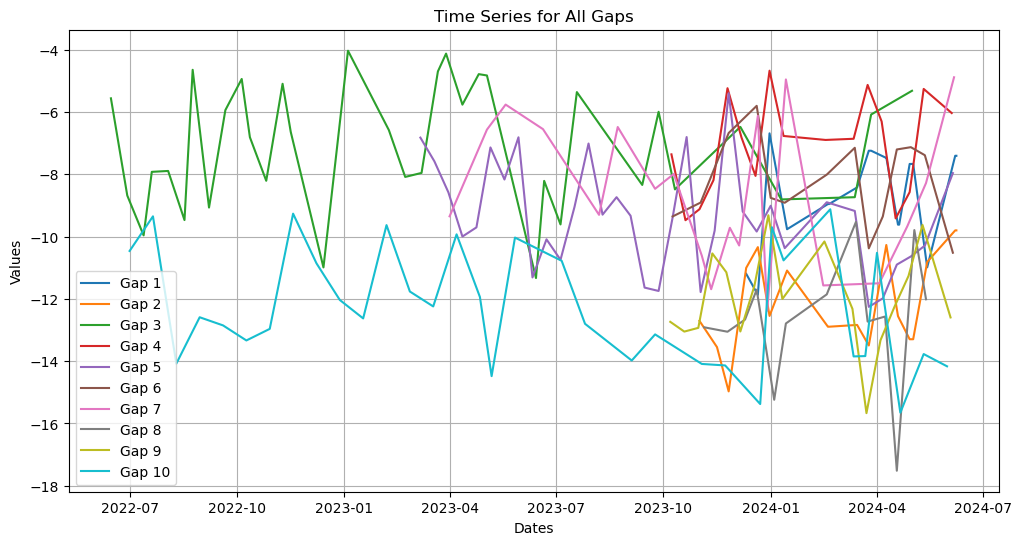

In [10]:
plt.figure(figsize=(12, 6))

for i in range(len(all_gap_timeseries)):
    dates = all_gap_timeseries[i, 0]
    values = all_gap_timeseries[i, 1]
    plt.plot(dates, values, label=f'Gap {i+1}')

plt.xlabel('Dates')
plt.ylabel('Values')
plt.title('Time Series for All Gaps')
plt.legend()
plt.grid(True)
plt.show()